In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M:%S"))

Summary run: Fri, 30 Apr 2021 11:16:01


In [3]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [4]:
pd.options.display.float_format = '{:0,.0f}'.format

In [5]:
# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [6]:
tod_dict = {
    '5to6': 'AM',
    '6to7': 'AM',
    '7to8': 'AM',
    '8to9': 'AM',
    '9to10': 'Mid-Day',
    '10to14': 'Mid-Day',
    '14to15': 'Mid-Day',
    '15to16': 'PM',
    '16to17': 'PM',
    '17to18': 'PM',
    '18to20': 'Evening',
    '20to5': 'Night'
}

purp_dict = {
    0: 'Home',
    1: 'Work',
    2: 'School',
    3: 'Escort',
    4: 'Personal Business',
    5: 'Shopping',
    6: 'Meal',
    7: 'Social',
    8: 'Recreational',
    9: 'Medical',
    10: 'Change Mode'
}

In [7]:
# Load Network Summary sheet from network_summary_detailed
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','VMT by FC')

## Vehicle Miles Traveled (VMT)

In [8]:
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['VMT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VMT']]

# Save total VMT for later use
total_vmt = df_tod.loc['Total'].values[0]

df_fac = pd.DataFrame(df.sum()[['arterial','highway','connector']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VMT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,VMT
Facility Type,
arterial,"44,729,051"
highway,"49,242,206"
connector,"6,769,742"
Total,"100,740,999"


,VMT
period,
am,"23,355,321"
ev,"12,668,795"
md,"33,705,298"
ni,"7,442,545"
pm,"23,569,041"
Total,"100,740,999"


## Vehicle Hours Traveled (VHT)

In [9]:
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','VHT by FC')
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['VHT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VHT']]

df_fac = pd.DataFrame(df.sum()[['arterial','highway','connector']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VHT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,VHT
Facility Type,
arterial,"33,333,334,001,364,209,664"
highway,"1,396,231"
connector,"430,933"
Total,"33,333,334,001,366,036,48"


,VHT
period,
am,"13,333,333,600,545,910,784"
ev,"5,000,000,100,204,819,456"
md,"5,000,000,100,205,410,304"
ni,"198,042"
pm,"10,000,000,200,409,698,304"
Total,"33,333,334,001,366,036,480"


## Delay

In [10]:
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','delay by FC')
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['Delay'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['Delay']]

df_fac = pd.DataFrame(df.sum()[['arterial','highway']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'Delay']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,Delay
Facility Type,
arterial,"251,385"
highway,"474,148"
Total,"725,533"


,Delay
period,
am,"272,931"
ev,"70,835"
md,"100,184"
ni,0
pm,"281,583"
Total,"725,533"


## VMT per Person

In [11]:
# Load Daysim results
trip = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_trip.tsv', sep='\t')
person = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_person.tsv', sep='\t')

In [12]:
# Load survey results
survey_trip = pd.read_csv(os.path.join(survey_path,'_trip.tsv'), delim_whitespace=True)
survey_person = pd.read_csv(os.path.join(survey_path,'_person.tsv'), delim_whitespace=True)

C:\Program Files\INRO\Emme\Emme 4\Emme-4.5.0\Python37\Lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
pd.options.display.float_format = '{:0,.2f}'.format


# This is average trips
model_value = trip['trexpfac'].sum()/person['psexpfac'].sum()
survey_value = survey_trip['trexpfac'].sum()/survey_person['psexpfac'].sum()

_df = pd.DataFrame([total_vmt/person['psexpfac'].sum()])
_df.columns = ['Average VMT per Capita']
_df

,Average VMT per Capita
0,17.53


## Trips per Person

In [14]:
model_result = (trip['trexpfac'].sum()*1.0)/person['psexpfac'].sum()
survey_result = (survey_trip['trexpfac'].sum()*1.0)/survey_person['psexpfac'].sum()

_df = pd.DataFrame([model_result,survey_result])
_df.columns = ['Total Trips per Capita']
_df.index = ['Model', 'Survey']
_df

,Total Trips per Capita
Model,4.09
Survey,3.45


## Trip Distance by Purpose

In [15]:
trip['wt_dist'] = trip['trexpfac']*trip['travdist']
_df = pd.DataFrame(trip.groupby('dpurp').sum()['wt_dist']/trip.groupby('dpurp').sum()['trexpfac']).reset_index()

survey_trip['wt_dist'] = survey_trip['trexpfac']*survey_trip['travdist']
_df_survey = pd.DataFrame(survey_trip.groupby('dpurp').sum()['wt_dist']/survey_trip.groupby('dpurp').sum()['trexpfac']).reset_index()
_df = _df.merge(_df_survey, on='dpurp', suffixes=['_model', '_survey'])
_df.rename(columns={'0_model': 'Model', '0_survey': 'Survey', 'dpurp': 'Trip Purpose'}, inplace=True)
_df['Trip Purpose'] = _df['Trip Purpose'].map(purp_dict)

# Add a row for totals
model_result = (trip['travdist']*trip['trexpfac']).sum()/trip['trexpfac'].sum()
survey_result = (survey_trip['travdist']*survey_trip['trexpfac']).sum()/survey_trip['trexpfac'].sum()
_df.loc[len(_df)] = ['All Trips',model_result, survey_result]
_df

,Trip Purpose,Model,Survey
0,Home,4.86,5.94
1,Work,6.86,8.45
2,School,3.03,4.56
3,Escort,4.65,4.81
4,Personal Business,4.17,5.25
5,Shopping,3.50,4.49
6,Meal,2.67,4.40
7,Social,3.82,4.70
8,Change Mode,8.85,14.55
9,All Trips,4.66,5.75


## Transit Boardings

In [16]:
df = pd.read_csv(os.path.join(relative_path,'transit','daily_boardings_by_agency.csv'),index_col=0)
df.loc['Region Total','boardings'] = df['boardings'].sum()
df

,boardings
agency_name,
King County Metro,"897,511.03"
Sound Transit,"817,220.36"
Community Transit,"139,217.81"
Pierce Transit,"89,628.08"
Kitsap Transit,"22,247.54"
Everett Transit,"19,397.84"
Washington Ferries,"4,753.40"
Region Total,"1,989,976.06"


## Trip Mode Share

,Model,Survey
mode,,
Walk,19.4%,11.6%
Bike,1.8%,0.8%
SOV,34.9%,41.6%
HOV2,21.5%,22.4%
HOV3+,14.8%,16.6%
Transit,5.6%,4.1%
School Bus,2.0%,1.4%


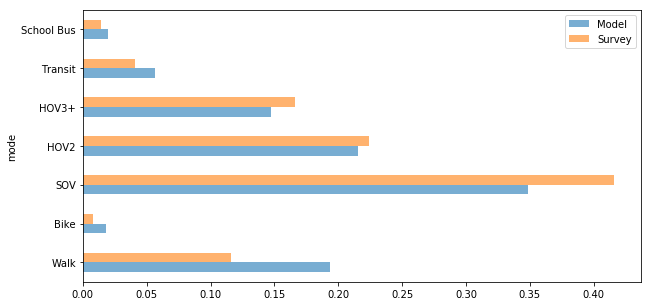

In [17]:
pd.options.display.float_format = '{:,.1%}'.format
model_df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
model_df = model_df.reset_index()
survey_df = survey_trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/survey_trip[['trexpfac']].sum()
survey_df = survey_df.reset_index()
_df = pd.merge(model_df, survey_df, on='mode', how='left')
_df.columns = ['mode','Model', 'Survey']
# _df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
# _df = _df.reset_index()
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
_df.replace({'mode':mode_dict}, inplace=True)
_df.index = _df['mode']
_df.drop('mode', axis=1, inplace=True)
dfplot = _df.drop('Other', axis=0)
dfplot.plot(kind='barh', alpha=0.6, figsize=(10,5))
display(dfplot)


# Home-Based Work Trip Mode Share

In [18]:
trip['Trip Type'] = 'Not Home-Based Work'
trip.loc[(((trip['opurp']==0) & (trip['dpurp']==1)) | ((trip['opurp']==1) & (trip['dpurp']==0))),'Trip Type']= 'Home-Based Work'
hbw_trips = trip.loc[trip['Trip Type']=='Home-Based Work']
model_df_hbw = hbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/hbw_trips[['trexpfac']].sum()
model_df_hbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
model_df_hbw.replace({'mode':mode_dict}, inplace=True)
model_df_hbw.columns = ['mode', 'share']
model_df_hbw

# Survey trip
survey_trip.loc[(((survey_trip['opurp']==0) & (survey_trip['dpurp']==1)) | ((survey_trip['opurp']==1) & (survey_trip['dpurp']==0))),'Trip Type']= 'Home-Based Work'
survey_hbw_trips = survey_trip.loc[survey_trip['Trip Type']=='Home-Based Work']
survey_df_hbw = survey_hbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/survey_hbw_trips[['trexpfac']].sum()
survey_df_hbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
survey_df_hbw.replace({'mode':mode_dict}, inplace=True)
survey_df_hbw.columns = ['mode', 'share']

model_df_hbw.merge(survey_df_hbw, on='mode', suffixes=['_model','_survey']).reset_index()

,index,mode,share_model,share_survey
0,0,Walk,13.2%,5.7%
1,1,Bike,1.9%,1.2%
2,2,SOV,58.3%,69.6%
3,3,HOV2,9.9%,8.8%
4,4,HOV3+,4.4%,2.4%
5,5,Transit,12.4%,10.3%
6,6,School Bus,0.0%,0.0%


# Other Trip Mode Share (Not Home-Based Work)

In [19]:
nhbw_trips = trip.loc[trip['Trip Type']!='Home-Based Work']
model_df_nhbw = nhbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/nhbw_trips[['trexpfac']].sum()
model_df_nhbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
model_df_nhbw.replace({'mode':mode_dict}, inplace=True)
model_df_nhbw.columns = ['mode', 'share']


# Survey trip
survey_nhbw_trips = survey_trip.loc[trip['Trip Type']!='Home-Based Work']
survey_df_nhbw = survey_nhbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/survey_nhbw_trips[['trexpfac']].sum()
survey_df_nhbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
survey_df_nhbw.replace({'mode':mode_dict}, inplace=True)
survey_df_nhbw.columns = ['mode', 'share']


survey_df_nhbw.merge(model_df_nhbw, on='mode', suffixes=['_model','_survey']).reset_index()

,index,mode,share_model,share_survey
0,0,Walk,11.6%,20.5%
1,1,Bike,0.8%,1.8%
2,2,SOV,41.1%,30.7%
3,3,HOV2,22.7%,23.6%
4,4,HOV3+,16.8%,16.6%
5,5,Transit,4.0%,4.4%
6,6,School Bus,1.5%,2.3%
